# CNN 大課題

## 導入

### 【課題】CNNとはどういった手法なのか記述せよ
CNNとはどういったものでしょうか。一般的なディープラーニングとの比較もしながら説明してください。

答え：

CNNとは主に画像認識に利用されるニューラルネットワークNNである。

一般的なNNは全結合層といって層と層の間のすべてのニューロンが接続されています。これではピクセルの位置情報が消失してしまい，画像を対象とするときこれでは不都合です。

一般的なNNとの違いは，CNNは畳み込み層やプーリング層があることです。これらは層の間で位置情報を保持したまま情報量を絞っていくことができます。

### 【課題】畳み込み層とプーリング層について記述せよ
CNNにおける畳み込み層とプーリング層について説明してください。パディングとストライドとは何かということも含めてください。

答え：

畳み込み層はフィルタという枠を通して次の層に値を渡します。2次元の場合ですと入力も2次元，フィルタも2次元になり，入力にフィルタという枠を当てはめて各値の積をとり総和を次の層に渡します。フィルタという枠を少しずつずらしながらすべての入力に対して積と総和を行います。

このフィルタのずらし量をストライドと言い，1, 2, 3...のような値をとります。

配列を小さくしたくない場合は，入力の配列の外側を0や縁の値で埋めてからフィルタをかけます。これをパディングと言います。

プーリング層はフィルタではない枠を当てはめてその枠内の最大値や平均値を出力します。ストライドの数だけ枠をずらしがらすべての入力に対して1つの枠から1つの値を出力します。パディングのやり方も畳み込み層と同じです。

### 【課題】CNNの精度を向上させるためにはどのようなことをするのが良いか記述せよ
CNNの精度を向上させたいときに行うことを説明してください。

答え：

- フィルタの数を複数にすることで表現力を豊かにする。例えばフィルタを2つにすると出力は2チャンネルになる。
- 最終段の全結合層については，層の数を増やしたりノードの数を増やすとより複雑になる。
- 畳み込み層とプーリング層の組合せを替えたり段数を増やす。
- 過学習を防ぐためにドロップアウト層を入れたりする。
- 層が増えて勾配消失がおきる可能性があるときはBatch Normalization層を入れると防ぐことができる。

### 必要なライブラリをimport

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import time
start = time.time()

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


## データ取得

### 【課題】データの読み込み

In [2]:
#load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### データセットの確認

In [3]:
print('X_train.shape : ',X_train.shape)
print('y_train.shape : ',y_train.shape)
print('X_test.shape : ',X_test.shape)
print('y_test.shape : ',y_test.shape)
print('y_test[0:10] : ',y_test[0:10])

X_train.shape :  (50000, 32, 32, 3)
y_train.shape :  (50000, 1)
X_test.shape :  (10000, 32, 32, 3)
y_test.shape :  (10000, 1)
y_test[0:10] :  [[3]
 [8]
 [8]
 [0]
 [6]
 [6]
 [1]
 [6]
 [3]
 [1]]


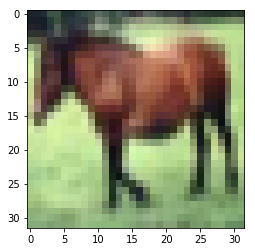

In [4]:
#指定したラベルのインデックスを取得する
tmp  = np.where(y_train==7)[0][0]

plt.imshow(X_train[tmp])

### 【課題】画像をまとめて表示

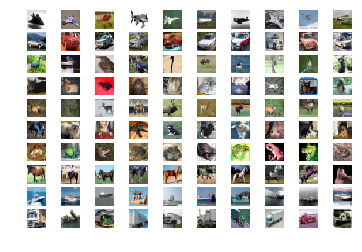

In [5]:
nclasses = 10 
pos = 1 
for i in range(nclasses): 
    targets = np.where(y_train==i)[0]
    for idx in targets[:10]: 
        plt.subplot(10, 10, pos) 
        img = X_train[idx] 
        plt.imshow(img) 
        plt.axis('off') 
        pos += 1 
plt.show() 

In [6]:
#画像サイズを取得
IMG_ROWS = X_train[0].shape[1]
IMG_COLS = X_train[0].shape[0]
#分類する数を取得
NB_CLASSES = len(set(y_train.flatten()))
#入力データの形状を取得
INPUT_SHAPE = X_train.shape[1:4]

print(IMG_ROWS, IMG_COLS, NB_CLASSES, INPUT_SHAPE)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

32 32 10 (32, 32, 3)
50000 train samples
10000 test samples


### 【課題】正規化

In [7]:
# float and normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

### 【課題】one-hot表現への変換

In [8]:
# convert to categorical
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES) 

## CNNの実装

### 【課題】モデルを作成

In [9]:
#constant
BATCH_SIZE = 128
NB_EPOCH = 20

VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = Adadelta()

# network

model = Sequential()

model.add(Conv2D(
    6, kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    activation='relu',
    input_shape=INPUT_SHAPE)
)
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2,2),
    padding='valid')
)
model.add(Conv2D(
    16, kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    activation='relu')
)
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2,2),
    padding='valid')
)
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(NB_CLASSES, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               123000    
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

### 【課題】このようなモデルにした理由

答え：

DICのテキストでMNISTのCNNで使った__LeNet__改良型をそのまま使いました。

__LeNet__改良型のオリジナルからの変更点は，
- Subsampling層をMaxpooling層に置換している
- 活性化関数をsigmoidからReLUに変更している
- 全結合層が2層から3層に変更されている

この改良のおかげでMNISTでは__AlexNet__と同等のAccuracyでした。

本格的なディープラーニングではCIFAR10の訓練に10時間以上かかりそうであり，とてもデバッグできません。

この大課題が動くようになるまで数日かかっています。デバッグに多大な時間がかかっており，モデルとしては，__LeNet__改良型で十分と考えました。

### 【課題】CNNの実行

In [10]:
# train

model.compile(
    loss='categorical_crossentropy', 
    optimizer=OPTIM,
    metrics=['accuracy']
)

history = model.fit(
    X_train, Y_train, 
    batch_size=BATCH_SIZE,epochs=NB_EPOCH, 
    validation_split=VALIDATION_SPLIT, 
    verbose=VERBOSE
)

print('Testing...')
score = model.evaluate(
    X_test, Y_test,
    batch_size=BATCH_SIZE, 
    verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 66s 2ms/step - loss: 1.9180 - acc: 0.3090 - val_loss: 1.5556 - val_acc: 0.4424
Epoch 2/20
40000/40000 [==============================] - 67s 2ms/step - loss: 1.4679 - acc: 0.4734 - val_loss: 1.4742 - val_acc: 0.4706
Epoch 3/20
40000/40000 [==============================] - 67s 2ms/step - loss: 1.3118 - acc: 0.5304 - val_loss: 1.4024 - val_acc: 0.5135
Epoch 4/20
40000/40000 [==============================] - 68s 2ms/step - loss: 1.2149 - acc: 0.5690 - val_loss: 1.2538 - val_acc: 0.5539
Epoch 5/20
40000/40000 [==============================] - 68s 2ms/step - loss: 1.1307 - acc: 0.6008 - val_loss: 1.2095 - val_acc: 0.5718
Epoch 6/20
40000/40000 [==============================] - 67s 2ms/step - loss: 1.0547 - acc: 0.6293 - val_loss: 1.1779 - val_acc: 0.5942
Epoch 7/20
40000/40000 [==============================] - 68s 2ms/step - loss: 0.9865 - acc: 0.6546 - val_loss: 1.1944 - val_acc

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


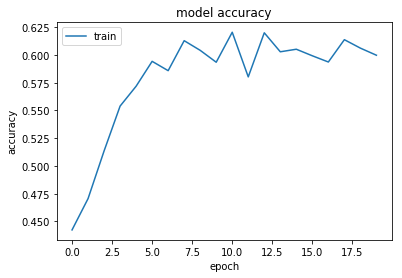

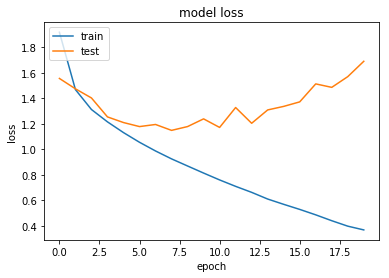

elapsed_time:1373.5463831424713


In [11]:
#save model
model_json = model.to_json()
open('cifar10_architecture.json', 'w').write(model_json)
model.save_weights('cifar10_weights.h5', overwrite=True)


# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(mo)
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time))